# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


Целевой признак
- Price — цена (евро)

**План работы:**

1. Подготовить данные:
- изучить данные;
- провести статистический анализ;
- провести предобработку данных;
2. Обучить разные модели, использовав различные гиперпараметры
- разбить данные на выборки;
- обучить несколько моделей и расчитать RMSE на обучающей выборке;
- выбрать модели с наилучшими показателями.
3. Проанализировать скорость работы и качество моделей
- обучить выбранные модели и расчитать RMSE на тестовой выборке;
- сделать вывод.

## Подготовка данных

### Предобработка данных

In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.datasets import load_iris
from sklearn.datasets import  make_classification

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

from catboost import Pool, cv, CatBoostRegressor

import warnings
warnings.simplefilter("ignore")
import warnings
warnings.filterwarnings("ignore")

from numpy.random import RandomState
STATE = RandomState(12345)


In [2]:
# загрузим данные 

try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
# изучим общую информацию 
 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# проверим пропуски

data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
# проверим на наличие дубликатов

print(f'Дубликатов в таблице: {data.duplicated().sum()}')

Дубликатов в таблице: 4


In [6]:
# получим статистические данные 

data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
# проверим сколько нулевых значений есть в столбцах Power и Price

power = data.loc[data['Power'] == 0, ['Power']]
print(power.count())

price = data.loc[data['Price'] == 0, ['Price']]
print(price.count())

Power    40225
dtype: int64
Price    10772
dtype: int64


**Вывод**

- таблица состоит из 14 столбцов и более 350 000 строк;
- собержит данные об автомобилях (тип кузова, тип топлива, мощьность, дата регистрации, пробег, марка и т.д.);
- данные представлены в виде типов object и int;
- имеются пропуски (в столбцах - VehicleType, Gearbox, Model, FuelType и NotRepaired);
- дубликатов всего четыре;
- также в таблице есть нулевые значения.

Приведем наименования столбцов в нужный вид.

Нулевые значения в нкеоторых столбцах тоже необходимо обработать. Цена и мощность не могут быть равны нулю. Можно заменить на значения похожих автомобилей по году, марке и модели. Отсальные строчки удалим. 

Необходимо обработать пропуски:
1. Для столбца NotRepaired пропущенные значения можно заменить на 'no' - в данном столбце только два значения (yes и no), скорей всего поле было пропущено так как машиyа не была в ремонте;
2. Пропуски в столбцах Model, VehicleType, Gearbox и FuelType попробуем удалить, так как все столбцы имеют различные строковые значение.

И можно использовать одно значение в случае с типами топлива petrol и gasoline - это одно и то же.

Столбцы DateCrawled, RegistrationMonth, DateCreated, LastSeen и PostalCode удаляем, так как они не информативны в нашем случае. Также удаляем столбец NumberOfPictures - все значения равны 0.

Дубликаты не будем удалять или править - для такого объема данных, 4 дубликата не исказят результаты.



In [8]:
# приведем в порядок наименования столбцов 

data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [9]:
# поменяем тип топлива gasoline на petrol

data.loc[data['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

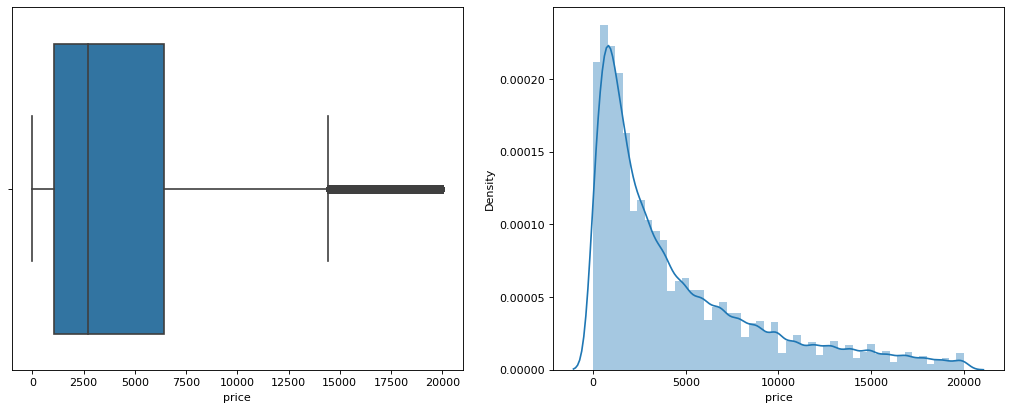

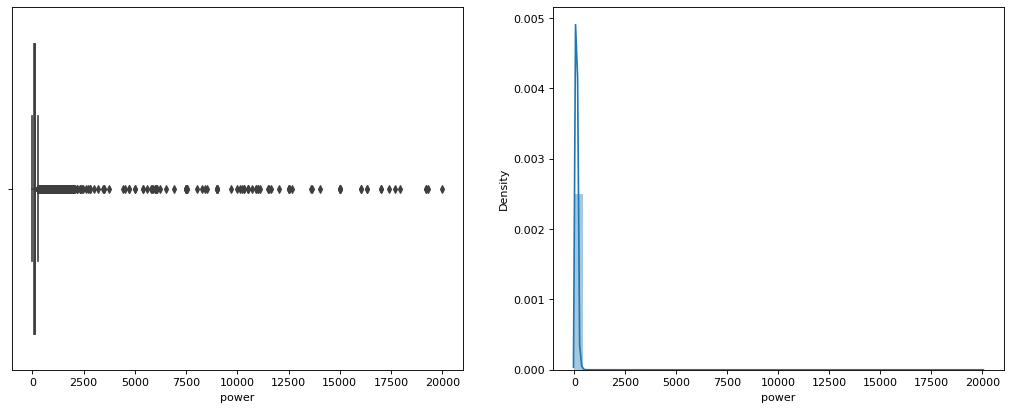

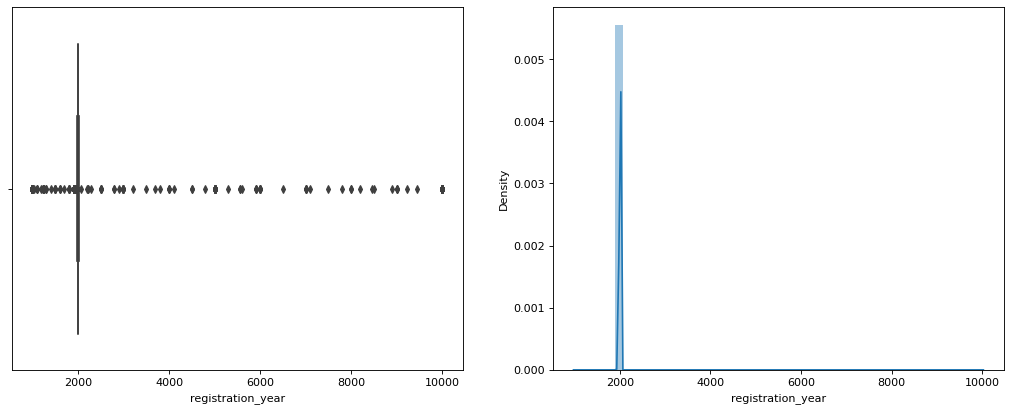

In [10]:
# проверим выбросы и распределение 
# для цены
price = data['price']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
sns.boxplot(price, ax=ax1)
sns.distplot(price, ax=ax2)
plt.show()

# для мощности
power = data['power']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
sns.boxplot(power, ax=ax1)
sns.distplot(power, ax=ax2)
plt.show()

# для года registration_year
year = data['registration_year']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
sns.boxplot(year, ax=ax1)
sns.distplot(year, ax=ax2)
plt.show()

- Выбросы имеются в каждом проверенном столбце, особенно в столбце с мощностью (все значения собраны в сотнях). В столбце с ценами выбросы начинаются на отметке 15 000, а с годом - 1980; 
- По распределениям выделяется столбец с ценами - экспоненциальное распределение (скорей всего из-за зависимости цены от года, большая часть машин свежего года, соответсвенно цена выше), остальные проверенные данные распределены нормально.

Итого:

Обработаем столбец с мощностью, так как не может быть мощности более 1300 л.с., год регистрации возьмем от 1960, цены от 500 до 15000


In [11]:
# определим значения в столбцах power и price
# для power значения от 40 до 1300 л.с.
# для price свыше 500

conditions = ((data['power'] >= 40) & (data['power'] <= 1300) & \
              (data['price'] >= 500) & (data['price'] <= 15000) & \
              (data['registration_year'] >= 1960))

data = data.loc[conditions]

# заполним медианами по марке, году и модели

data['power'] = data['power'].fillna(data.groupby(['brand', 'registration_year', \
                                                   'model'])['power'].transform('median'))


In [12]:
#код ревьюера
data[data['price']==200]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen


In [13]:
# заменим пропуски в not_repaired на no если пробег меньше 10000

data['not_repaired'] = np.where(data['kilometer'] < 10000, data['not_repaired'].fillna('no'), \
                                data['not_repaired'].fillna('yes'))


In [14]:
# проверим сколько марок и моделей у нас стоалось

cols = ['brand','model']
print(data[cols].nunique())

brand     40
model    249
dtype: int64


In [15]:
# попробуем удалить все оставшиеся строки с пропущенными значениями и проверим сколько данных мы потеряли

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237702 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        237702 non-null  object
 1   price               237702 non-null  int64 
 2   vehicle_type        237702 non-null  object
 3   registration_year   237702 non-null  int64 
 4   gearbox             237702 non-null  object
 5   power               237702 non-null  int64 
 6   model               237702 non-null  object
 7   kilometer           237702 non-null  int64 
 8   registration_month  237702 non-null  int64 
 9   fuel_type           237702 non-null  object
 10  brand               237702 non-null  object
 11  not_repaired        237702 non-null  object
 12  date_created        237702 non-null  object
 13  number_of_pictures  237702 non-null  int64 
 14  postal_code         237702 non-null  int64 
 15  last_seen           237702 non-null  object
dtypes:

- В процессе предобработки мы потеряли 33% данных, одну марку и одну модель автомобиля

In [16]:
# удалим столбцы date_crawled, registration_month, date_created, last_seen, number_of_pictures и postal_code

data = data.drop(['date_crawled','registration_month',\
                  'date_created','last_seen','number_of_pictures', 'postal_code'], axis=1)
data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,2010,manual,140,golf,150000,petrol,volkswagen,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no


In [17]:
# можно заменить yes и no на True(1) и False(0)

data['not_repaired'] = data['not_repaired'].map({'no':0, 'yes':1})

### Анализ данных

In [18]:
# посмотрим на корреляцию данных

data.corr()

,price,registration_year,power,kilometer,not_repaired
price,1.000000,0.558438,0.434455,-0.355031,-0.200877
registration_year,0.558438,1.000000,0.073420,-0.349122,-0.125002
power,0.434455,0.073420,1.000000,0.161018,-0.016660
kilometer,-0.355031,-0.349122,0.161018,1.000000,0.102880
not_repaired,-0.200877,-0.125002,-0.016660,0.102880,1.000000


- Из всех данных для цены самую высокую положительную корреляцию показывает год выпуска (0.5), а отрицательную - пробег (почти 0.4)

In [19]:
# посмотрим на статистические данные после обработки

data.describe()

,price,registration_year,power,kilometer,not_repaired
count,237702.000000,237702.00000,237702.000000,237702.000000,237702.000000
mean,4600.878916,2002.78524,120.867856,129614.517337,0.192329
std,3724.914695,5.72082,52.551249,35026.944454,0.394131
min,500.000000,1960.00000,40.000000,5000.000000,0.000000
25%,1550.000000,1999.00000,80.000000,125000.000000,0.000000
50%,3400.000000,2003.00000,114.000000,150000.000000,0.000000
75%,6800.000000,2007.00000,150.000000,150000.000000,0.000000
max,15000.000000,2018.00000,1300.000000,150000.000000,1.000000


- нулевые значения ушли
- год 1000 и 9999 так же исчезли
- остались значения, которые похожи на выбросы

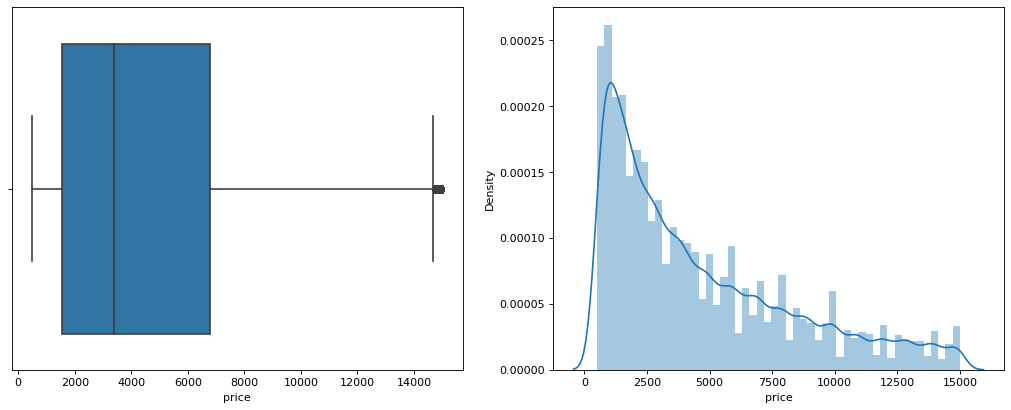

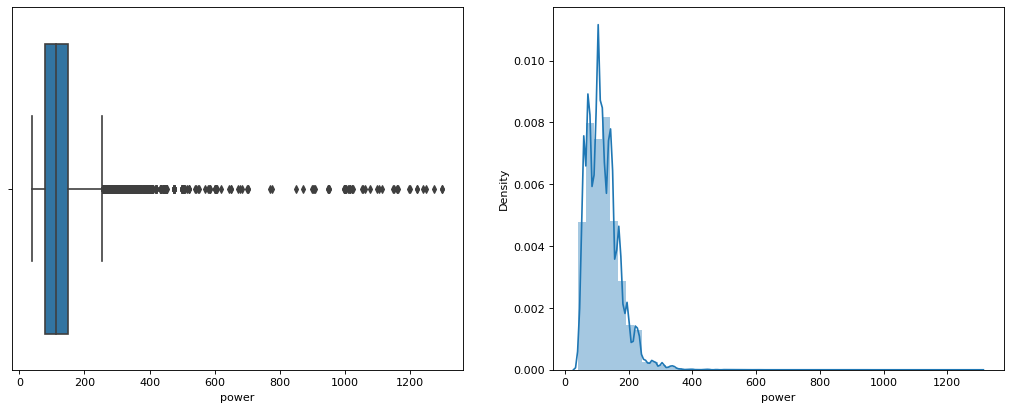

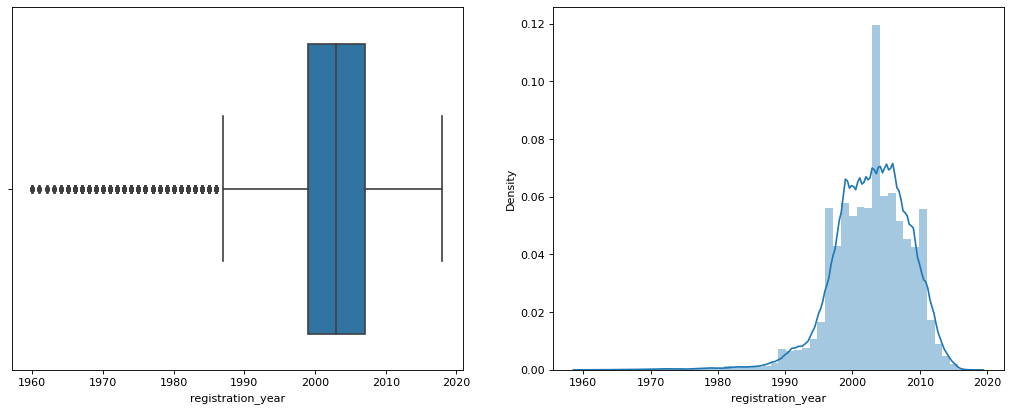

In [20]:
# снова проверим выбросы и распределение 
# для цены
price = data['price']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
sns.boxplot(price, ax=ax1)
sns.distplot(price, ax=ax2)
plt.show()

# для мощности
power = data['power']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
sns.boxplot(power, ax=ax1)
sns.distplot(power, ax=ax2)
plt.show()

# для года registration_year
year = data['registration_year']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
sns.boxplot(year, ax=ax1)
sns.distplot(year, ax=ax2)
plt.show()


- Картина с распределениями и выбросами стала лучше.

## Обучение моделей

### Подготовим данные

In [21]:
# напишем функцию расчета RMSE

def RMSE(predictions, target):
    rmse = MSE(predictions, target) ** 0.5
    return rmse


In [22]:
# поделим первоначальные данные на признаки

features = data.drop(['price'], axis=1)
target = data['price']

# поделим признаки на выборки

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=STATE)

print(f'Размер обучающей выборки: {features_train.shape[0]}')
print(f'Размер тестовой выборки: {features_test.shape[0]}')

Размер обучающей выборки: 166391
Размер тестовой выборки: 71311


In [23]:
# проведем прямое кодирование

data_ohe = pd.get_dummies(data, drop_first=True)


# поделим кодированные данные на признаки

features_ohe = data_ohe.drop(['price'], axis=1)
target_ohe = data_ohe['price']

# поделим признаки на выборки

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.3, random_state=12345)

print(f'Размер обучающей выборки: {features_train_ohe.shape[0]}')
print(f'Размер тестовой выборки: {features_test_ohe.shape[0]}')

Размер обучающей выборки: 166391
Размер тестовой выборки: 71311


### Подберем параметры и лучший результат с помощью GridSearchCV

In [24]:
# подготовим rmse для расчетов в моделях
rmse_score = make_scorer(RMSE, greater_is_better=False)

# подготовим необходимые параметры для GridSearchCV
cross = KFold(n_splits=5, shuffle=False)


In [25]:
# DecisionTreeRegressor

pipe_dtr = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('model', DecisionTreeRegressor(random_state=STATE))
])

params_dtr = {
        'imp__strategy': ['mean', 'median'],
        'model': [DecisionTreeRegressor(random_state=STATE)],
        'model__max_depth': range(2, 15, 2)
}

model_dtr = DecisionTreeRegressor()
start = time.time()

grid_dtr = GridSearchCV(pipe_dtr, param_grid=params_dtr, cv=cross, scoring=rmse_score)
grid_dtr.fit(features_train_ohe, target_train_ohe)
time_dtr = time.time() - start

print(f'Best params: {grid_dtr.best_params_}')
print(f'Best rmse score: {-grid_dtr.best_score_}')
print('%s seconds' % time_dtr)

Best params: {'imp__strategy': 'mean', 'model': DecisionTreeRegressor(max_depth=14,
                      random_state=RandomState(MT19937) at 0x7F014BA0B140), 'model__max_depth': 14}
Best rmse score: 1575.3851107622263
307.02730798721313 seconds


In [26]:
# LinearRegression

pipe_lr = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('model', LinearRegression())
])

param_lr = {
        'imp__strategy': ['mean', 'median'],
        'model': [LinearRegression()]
    }

model_lr = LinearRegression()
start = time.time()

grid_lr = GridSearchCV(pipe_lr, param_grid=param_lr, cv=cross, scoring=rmse_score, n_jobs=-1)
grid_lr = grid_lr.fit(features_train_ohe, target_train_ohe)
time_lr = time.time() - start

print(f'Best params: {grid_lr.best_params_}')
print(f'Best rmse score: {-grid_lr.best_score_}')
print('%s seconds' % time_lr)


Best params: {'imp__strategy': 'mean', 'model': LinearRegression()}
Best rmse score: 2117.109490215845
188.03761053085327 seconds


In [27]:
# Ridge

param_ridge = {
        'alpha': np.logspace(0.1, 1, 5),
        'max_iter': [400]
    }

model_ridge = Ridge(random_state=STATE)
start = time.time()

grid_ridge = GridSearchCV(model_ridge, param_grid=param_ridge, cv=cross, scoring=rmse_score)
grid_ridge = grid_ridge.fit(features_train_ohe, target_train_ohe)
time_ridge = time.time() - start

print(f'Best params: {grid_ridge.best_params_}')
print(f'Best rmse score: {-grid_ridge.best_score_}')
print('%s seconds' % time_ridge)


Best params: {'alpha': 1.2589254117941673, 'max_iter': 400}
Best rmse score: 2116.96632723481
50.50743126869202 seconds


In [42]:
# SGDRegressor

pipe_sgd = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('model', SGDRegressor(random_state=STATE))
])

param_sgd = { 
        'model': [SGDRegressor(random_state=STATE)],
        'model__max_iter': [600],
        'model__verbose': [0],
        'model__alpha': np.logspace(0.1, 1, 5)
    }

model_sgd = SGDRegressor(random_state=STATE)
start = time.time()

grid_sgd = GridSearchCV(pipe_sgd, param_grid=param_sgd, cv=cross, scoring=rmse_score)
grid_sgd = grid_sgd.fit(features_train_ohe, target_train_ohe)
time_sgd = time.time() - start

print(f'Best params: {grid_sgd.best_params_}')
print(f'Best rmse score: {-grid_sgd.best_score_}')
print('%s seconds' % time_sgd)


Best params: {'model': SGDRegressor(alpha=1.2589254117941673, max_iter=600,
             random_state=RandomState(MT19937) at 0x7F014BA0B140), 'model__alpha': 1.2589254117941673, 'model__max_iter': 600, 'model__verbose': 0}
Best rmse score: 2584.337750078002
178.07590007781982 seconds


In [46]:
# проверим работу CatBoostRegressor

cat_model = CatBoostRegressor()
start = time.time()

cat_model.fit(features_train, target_train, eval_set=(features_test, target_test), \
        cat_features=['vehicle_type', 'registration_year', 'gearbox', 'power', \
                      'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired'], verbose=200)

time_cat = time.time() - start

print('%s seconds' % time_cat)


Learning rate set to 0.113661
0:	learn: 3466.5668948	test: 3475.5047127	best: 3475.5047127 (0)	total: 175ms	remaining: 2m 54s
200:	learn: 1472.9257803	test: 1472.4846825	best: 1472.4846825 (200)	total: 29.1s	remaining: 1m 55s
400:	learn: 1419.1670663	test: 1434.2929865	best: 1434.2929865 (400)	total: 59.5s	remaining: 1m 28s
600:	learn: 1385.8943638	test: 1415.5048325	best: 1415.5048325 (600)	total: 1m 30s	remaining: 1m
800:	learn: 1364.5963275	test: 1404.7507418	best: 1404.7507418 (800)	total: 2m 3s	remaining: 30.7s
999:	learn: 1346.4894771	test: 1396.2663387	best: 1396.2663387 (999)	total: 2m 34s	remaining: 0us

bestTest = 1396.266339
bestIteration = 999

157.21636199951172 seconds


In [44]:
# посмотрим какие параметры использовала CatBoostRegressor

for key,value in cat_model.get_all_params().items():
 print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, RMSE
combinations_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations, 1000
sampling_frequency, PerTree
fold_permutation_block, 0
leaf_estimation_method, Newton
counter_calc_method, SkipTest
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
ctr_leaf_count_limit, 18446744073709551615
bayesian_matrix_reg, 0.10000000149011612
one_hot_max_size, 2
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, True
max_ctr_complexity, 4
model_size_reg, 0.5
simple_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
pool_metainfo_options, {'tags': {}}
s

In [53]:
# проверим работу LightGBM

features_cols = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'not_repaired']

features_train = features_train.astype('category')
features_test = features_test.astype('category')

lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_test, target_test, reference=lgb_train)

estimator = lgb.LGBMRegressor()

params = {
    'task': 'train',
    'boosting_type': 'gbdt',  
    'objective': 'regression', 
    'metric': {'l2', 'RMSE'}, 
    'num_leaves': 31, 
    'learning_rate': 0.1,
    'feature_fraction': 0.6, 
    'bagging_fraction': 0.6, 
    'bagging_freq': 5, 
    'verbose': 1
}

time_lgb = time.time() - start

gbm = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, \
                categorical_feature=features_cols, early_stopping_rounds=5)
y_pred = gbm.predict(features_test, num_iteration=gbm.best_iteration)
rmse_res = RMSE(target_test, y_pred)

time_cat = time.time() - start

print('The rmse of prediction is:', rmse_res)
print('%s seconds' % time_lgb)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.482743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 166391, number of used features: 9
[LightGBM] [Info] Start training from score 4600.298141
[1]	valid_0's l2: 1.20088e+07	valid_0's rmse: 3465.38
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 1.10159e+07	valid_0's rmse: 3319.02
[3]	valid_0's l2: 1.00888e+07	valid_0's rmse: 3176.29
[4]	valid_0's l2: 8.8125e+06	valid_0's rmse: 2968.59
[5]	valid_0's l2: 7.78497e+06	valid_0's rmse: 2790.16
[6]	valid_0's l2: 7.00916e+06	valid_0's rmse: 2647.48
[7]	valid_0's l2: 6.29055e+06	valid_0's rmse: 2508.1
[8]	valid_0's l2: 5.8259e+06	valid_0's rmse: 2413.69
[9]	valid_0's l2: 5.29841e+06	valid_0's rmse: 2301.83
[10]	valid_0's l2: 4.85177e+06	valid_0's rmse:

In [49]:
# посмотрим какие параметры использовала LGBMRegressor

for key,value in estimator.get_params().items():
 print('{}, {}'.format(key,value))

boosting_type, gbdt
class_weight, None
colsample_bytree, 1.0
importance_type, split
learning_rate, 0.1
max_depth, -1
min_child_samples, 20
min_child_weight, 0.001
min_split_gain, 0.0
n_estimators, 100
n_jobs, -1
num_leaves, 31
objective, None
random_state, None
reg_alpha, 0.0
reg_lambda, 0.0
silent, warn
subsample, 1.0
subsample_for_bin, 200000
subsample_freq, 0


**Выведем таблицу с полученными значениями**

In [54]:
first_results = {'DecisionTreeRegressor': [-grid_dtr.best_score_, time_dtr], 
                 'LinearRegression': [-grid_lr.best_score_, time_lr], 
                 'Ridge': [-grid_ridge.best_score_, time_ridge], 
                 'SGD': [-grid_sgd.best_score_, time_sgd], 
                 'CatBoostRegressor': [1396.266339, time_cat], 
                 'LGBMRegressor': [rmse_res, time_lgb]}

total_frame = pd.DataFrame(first_results, index=['RMSE', 'time'])
total_frame

,DecisionTreeRegressor,LinearRegression,Ridge,SGD,CatBoostRegressor,LGBMRegressor
RMSE,1575.385111,2117.109490,2116.966327,2584.33775,1396.266339,1738.274080
time,307.027308,188.037611,50.507431,178.07590,610.942218,529.537145


- Наилучший показатель RMSE показала модель CatBoostRegressor
- Наилучшее время у модели Ridge

Исходя из полученных данных, анализ моделей будем проводить на DecisionTreeRegressor, CatBoostRegressor и LGBMRegressor.

## Анализ моделей

### Проверим наши модели на тестовой выборке

In [62]:
# проверим работу DecisionTreeRegressor

model_dtr = DecisionTreeRegressor(random_state=STATE, max_depth=14)
start_time = time.time()

model_dtr.fit(features_train_ohe, target_train_ohe)
predictions_dtr = model_dtr.predict(features_test_ohe)
result_dtr = RMSE(predictions_dtr, target_test_ohe)

time_dtr_1 = (time.time() - start_time)

print('%s seconds' % time_dtr_1)
print()
print(f' RMSE: {result_dtr}')

3.628206253051758 seconds

 RMSE: 1574.929385813174


In [64]:
# проверим работу CatBoostRegressor на тестовой выборке с параметрами полученными выше

cat = CatBoostRegressor(loss_function='RMSE', 
                        iterations=1000, 
                        learning_rate=0.11, 
                        thread_count=-1,  
                        max_depth=6, 
                        l2_leaf_reg=3, 
                        max_leaves=64)

start = time.time()
cat.fit(features_train, target_train, eval_set=(features_test, target_test), \
        cat_features=['vehicle_type', 'registration_year', 'gearbox', 'power', \
                      'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired'], verbose=False, plot=True);

time_cat_1 = time.time() - start_time

print('%s seconds' % time_cat_1)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

187.44466638565063 seconds


In [65]:
# проверим работу LGBMRegressor на тестовой выборке

model_lgb = lgb.LGBMRegressor()
start = time.time()

params = {
    'task': 'train',
    'boosting_type': 'gbdt',  
    'objective': 'regression', 
    'metric': {'l2', 'RMSE'}, 
    'max_depth': -1, 
    'num_leaves': 31, 
    'learning_rate': 0.1
}

gbm_1 = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, \
                categorical_feature=features_cols, early_stopping_rounds=5)
y_pred = gbm_1.predict(featurcves_test, num_iteration=gbm.best_iteration)
result_lgb = RMSE(target_test, y_pred)


time_lgb_1 = time.time() - start

print('The rmse of prediction is:', result_lgb)
print('%s seconds' % time_lgb_1)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 166391, number of used features: 9
[LightGBM] [Info] Start training from score 4600.298141
[1]	valid_0's l2: 1.20021e+07	valid_0's rmse: 3464.4
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 1.04107e+07	valid_0's rmse: 3226.57
[3]	valid_0's l2: 9.09695e+06	valid_0's rmse: 3016.12
[4]	valid_0's l2: 8.01312e+06	valid_0's rmse: 2830.75
[5]	valid_0's l2: 7.09966e+06	valid_0's rmse: 2664.52
[6]	valid_0's l2: 6.35419e+06	valid_0's rmse: 2520.75
[7]	valid_0's l2: 5.73227e+06	valid_0's rmse: 2394.22
[8]	valid_0's l2: 5.2056e+06	valid_0's rmse: 2281.58
[9]	valid_0's l2: 4.76419e+06	valid_0's rmse: 2182.7
[10]	valid_0's l2: 4.39106e+06	valid_0's rmse:

**Выведем таблицу с полученными значениями**

In [66]:
second_results = {'DecisionTreeRegressor': [result_dtr, time_dtr_1], 
                 'CatBoostRegressor': [1398.086439, time_cat_1], 
                 'LGBMRegressor': [result_lgb, time_lgb_1]}

frame = pd.DataFrame(second_results, index=['RMSE', 'time'])
frame

,DecisionTreeRegressor,CatBoostRegressor,LGBMRegressor
RMSE,1574.929386,1398.086439,1638.883283
time,3.628206,187.444666,1.626867


- Наилучший показатель RMSE показала модель
- Наилучшее время у модели 

In [67]:
# также посмотрим какие резултаты даст нам константная модель

model_dummy = DummyRegressor()

model_dummy.fit(features_train_ohe, target_train_ohe)
pred = model_dummy.predict(features_test_ohe)
res = RMSE(pred, target_test_ohe)

print(f' RMSE на DummyRegressor: {res}')

 RMSE на DummyRegressor: 3734.328474099451



- Показатель RMSE на константной модели хуже, чем на выбранных нами моделях

## Общий вывод

1. В процессе предобработки мы потеряли 33% данных.
2. Обучили 3 модели и сравнили показатель RMSE в каждой. 
3. Наилучший результат RMSE на тестовой выборке показала модель CatBoostRegressor - 1398, но с наихудшим временем 187.44 секунд.
4. Наилучшее время выдала LGBMRegressor - 1.62 секунд, но RMSE - (самое высокое среди выбранных моделей).

Для более точного предсказания стоит выбрать модель CatBoostRegressor, но так как нам важно еще и время работы лучше использовать DecisionTreeRegressor (время у нее 3.62, а RMSE отличается от показателя в CatBoostRegressor не очень сильно).